In [1]:
# !pip install --user PyROQ==0.1.25

In [2]:
import numpy
import numpy as np
import scipy
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import lal
import lalsimulation
from lal.lal import PC_SI as LAL_PC_SI
import h5py
import warnings
import random
warnings.filterwarnings('ignore')
import matplotlib.pylab as pylab
plot_params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(plot_params)
from mpl_toolkits.mplot3d import axes3d
#import PyROQ.pyroq as pyroq
import sys
sys.path.insert(0, "../Code/PyROQ/")
import pyroq as pyroq

# Setting up boundary conditions and tolerance requirements.

In [3]:
mc_low = 20
mc_high = 30
q_low = 1
q_high = 2
s1sphere_low = [0, 0, 0]
s1sphere_high = [0.2, numpy.pi, 2.0*numpy.pi]
s2sphere_low = [0, 0, 0]
s2sphere_high = [0.2, numpy.pi, 2.0*numpy.pi]
ecc_low = 0.0
ecc_high = 0.2
lambda1_low = 0
lambda1_high = 1000
lambda2_low = 0
lambda2_high = 1000
iota_low = 0
iota_high = numpy.pi
phiref_low = 0
phiref_high = 2*numpy.pi
f_min = 20
f_max = 1024
deltaF = 1/4.
distance = 10 * LAL_PC_SI * 1.0e6  # 10 Mpc is default 
waveFlags = lal.CreateDict()
approximant = lalsimulation.IMRPhenomPv2
print("mass-min, mass-max: ", pyroq.massrange(mc_low, mc_high, q_low, q_high))

parallel = 1 # The parallel=1 will turn on multiprocesses to search for a new basis. To turn it off, set it to be 0.
             # Do not turn it on if the waveform generation is not slow compared to data reading and writing to files.
             # This is more useful when each waveform takes larger than 0.01 sec to generate.
nprocesses = 4 # Set the number of parallel processes when searching for a new basis.  nprocesses=mp.cpu_count()


nts = 10**3 # Number of random test waveforms
          # For diagnostics, 1000 is fine.
          # For real ROQs calculation, set it to be 1000000.

npts = 80 # Specify the number of points for each search for a new basis element
          # For diagnostic testing, 30 -100 is fine. 
          # For real ROQs computation, this can be 300 to 2000, roughly comparable to the number of basis elments.
          # What value to choose depends on the nature of the waveform, such as how many features it has. 
          # It also depends on the parameter space and the signal length. 
        
nbases = 80 # Specify the number of linear basis elements. Put your estimation here for the chunk of parameter space.
ndimlow = 40 # Your estimation of fewest basis elements needed for this chunk of parameter space.
ndimhigh = nbases+1 
ndimstepsize = 10 # Number of linear basis elements increament to check if the basis satisfies the tolerance.
tolerance = 1e-8 # Surrogage error threshold for linear basis elements

nbases_quad = 80 # Specify the number of quadratic basis elements, depending on the tolerance_quad, usually two thirds of that for linear basis
ndimlow_quad = 20
ndimhigh_quad = nbases_quad+1
ndimstepsize_quad = 10
tolerance_quad = 1e-10 # Surrogage error threshold for quadratic basis elements

mass-min, mass-max:  [16.437518295172257, 49.31255488551677]


In [4]:
freq = numpy.arange(f_min,f_max,deltaF)
nparams, params_low, params_high, params_start, hp1 = pyroq.initial_basis(mc_low, mc_high, q_low, q_high, s1sphere_low, s1sphere_high, \
                  s2sphere_low, s2sphere_high, ecc_low, ecc_high, lambda1_low, lambda1_high,\
                 lambda2_low, lambda2_high, iota_low, iota_high, phiref_low, phiref_high, distance, deltaF, f_min, f_max, waveFlags, approximant)


In [5]:
print(nparams)
print(len(freq))

10
4016


# Search for linear basis elements to build and save linear ROQ data in the local directory.

In [6]:
known_bases_start = numpy.array([hp1/numpy.sqrt(numpy.vdot(hp1,hp1))])
basis_waveforms_start = numpy.array([hp1])
residual_modula_start = numpy.array([0.0])
known_bases, params, residual_modula = pyroq.bases_searching_results_unnormalized(parallel, nprocesses, npts, nparams, nbases, known_bases_start, basis_waveforms_start, params_start, residual_modula_start, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)
print(known_bases.shape, residual_modula)


The parameters are Mc, q, s1(mag, theta, phi), s2(mag, theta, phi), iota, and phiRef

2019-11-18 11:57:02.099851 Start linear bases searching...
2019-11-18 11:57:02.228166 Linear Iter: 1 and new basis waveform [20.754118  1.388194  0.158121  1.282057  4.738707  0.183059  0.190052
  1.296208  0.205412  0.951191]
2019-11-18 11:57:02.350452 Linear Iter: 2 and new basis waveform [29.324562  1.814039  0.179381  0.050433  2.179353  0.193852  1.107244
  0.752737  2.87711   0.290906]
2019-11-18 11:57:02.471002 Linear Iter: 3 and new basis waveform [2.904987e+01 1.518261e+00 1.517000e-03 2.211607e+00 8.472520e-01
 1.968250e-01 2.056637e+00 3.598963e+00 1.295700e-02 4.923621e+00]
2019-11-18 11:57:02.593712 Linear Iter: 4 and new basis waveform [2.842076e+01 1.010737e+00 1.793980e-01 1.636980e+00 2.310012e+00
 9.388900e-02 6.540000e-03 3.541624e+00 2.911690e+00 1.121980e-01]
2019-11-18 11:57:02.716227 Linear Iter: 5 and new basis waveform [28.341902  1.699134  0.15059   2.702612  3.228004  0.0572

In [7]:
known_bases = numpy.load('./linearbases.npy')
pyroq.roqs(tolerance, freq, ndimlow, ndimhigh, ndimstepsize, known_bases, nts, nparams, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)


39 basis elements gave 255 bad points of surrogate error >  1e-08
49 basis elements gave 99 bad points of surrogate error >  1e-08
59 basis elements gave 0 bad points of surrogate error >  1e-08
Number of linear basis elements is  59 and the linear ROQ data are saved in B_linear.npy


In [8]:
fnodes_linear = numpy.load('./fnodes_linear.npy')
b_linear = numpy.transpose(numpy.load('./B_linear.npy'))
ndim = b_linear.shape[1]
freq = numpy.arange(f_min, f_max, deltaF)
emp_nodes = numpy.searchsorted(freq, fnodes_linear)
print(b_linear)
print("emp_nodes", emp_nodes)

[[ 1.00000000e+00+2.27373675e-12j -7.27595761e-12+3.27418093e-11j
  -7.09405867e-11+5.82076609e-11j ... -8.73114914e-11+1.81898940e-10j
   5.82076609e-11-5.52972779e-10j  1.16415322e-10+4.94765118e-10j]
 [-1.36424205e-11+3.63797881e-12j  1.00000000e+00-4.09272616e-11j
   3.63797881e-12-1.14596332e-10j ... -2.72848411e-10-1.45519152e-10j
   3.71073838e-10+4.07453626e-10j -9.31322575e-10-3.49245965e-10j]
 [ 6.23610264e-02-1.47905890e-02j  5.81302370e-02+4.05792280e-01j
   1.88944969e-01-9.70805493e-01j ...  1.74896616e-01-9.18449812e-03j
  -2.76031196e-01-5.12262297e-02j  5.16839933e-01-1.59194581e-01j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+

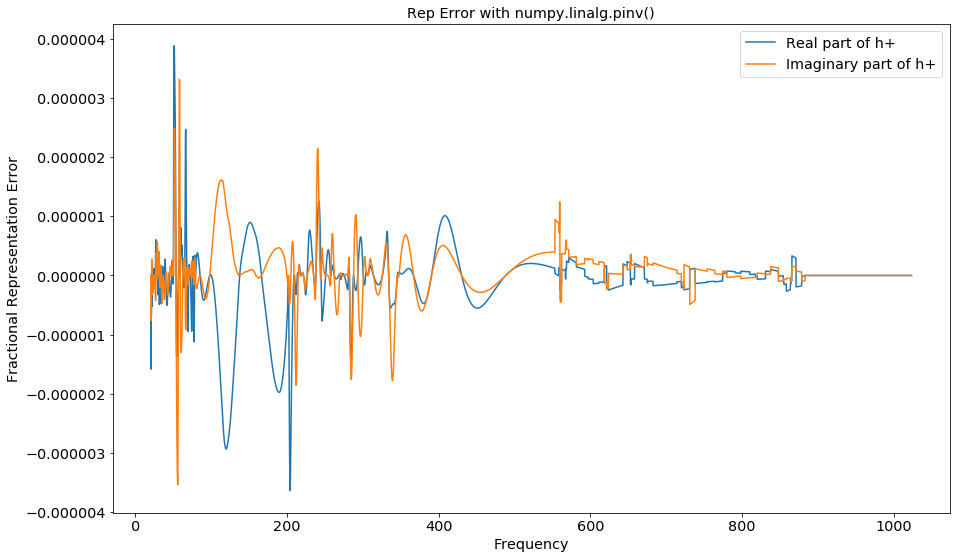

In [9]:
test_mc = 25
test_q = 2
test_s1 = [0.,0.2,-0.]
test_s2 = [0.,0.15,-0.1]
test_ecc = 0
test_lambda1 = 0
test_lambda2 = 0
test_iota = 1.9
test_phiref = 0.6

pyroq.testrep(b_linear, emp_nodes, test_mc, test_q, test_s1, test_s2, test_ecc, test_lambda1, test_lambda2, test_iota, test_phiref, distance, deltaF, f_min, f_max, waveFlags, approximant)


In [10]:
nsamples = 1000 # testing nsamples random samples in parameter space to see their representation surrogate errors
surros = pyroq.surros_of_test_samples(nsamples, nparams, params_low, params_high, tolerance, b_linear, emp_nodes, distance, deltaF, f_min, f_max, waveFlags, approximant)
# If a surrogate error is larger than tolerance, it will be reported on the screen.

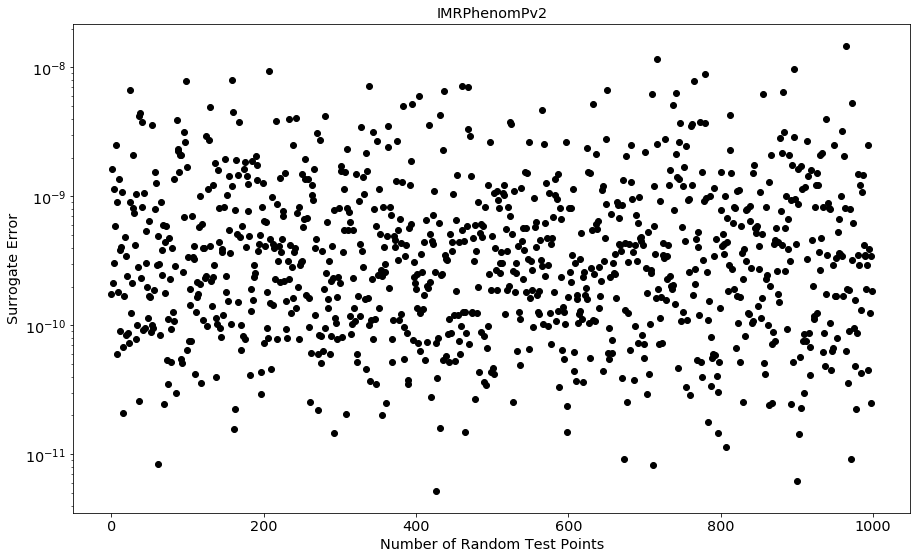

In [11]:
plt.figure(figsize=(15,9))
plt.semilogy(surros,'o',color='black')
plt.xlabel("Number of Random Test Points")
plt.ylabel("Surrogate Error")
plt.title("IMRPhenomPv2")
plt.savefig("SurrogateErrorsRandomTestPoints.png")
plt.show()

# Search for quadratic basis elements to build & save quadratic ROQ data.

In [12]:
hp1_quad = (numpy.absolute(hp1))**2
known_quad_bases_start = numpy.array([hp1_quad/numpy.sqrt(numpy.vdot(hp1_quad,hp1_quad))])
basis_waveforms_quad_start = numpy.array([hp1_quad])
residual_modula_start = numpy.array([0.0])
known_quad_bases,params_quad,residual_modula_quad = pyroq.bases_searching_quadratic_results_unnormalized(parallel, nprocesses, npts, nparams, nbases_quad, known_quad_bases_start, basis_waveforms_quad_start, params_start, residual_modula_start, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)
known_quad_bases_copy = known_quad_bases


2019-11-18 11:57:41.969170 Start quadratic bases searching...
2019-11-18 11:57:41.969413 Quadratic Iter:  1
2019-11-18 11:57:42.096735 Quadratic Iter:  2
2019-11-18 11:57:42.218413 Quadratic Iter:  3
2019-11-18 11:57:42.339979 Quadratic Iter:  4
2019-11-18 11:57:42.463914 Quadratic Iter:  5
2019-11-18 11:57:42.586843 Quadratic Iter:  6
2019-11-18 11:57:42.712099 Quadratic Iter:  7
2019-11-18 11:57:42.834360 Quadratic Iter:  8
2019-11-18 11:57:42.958660 Quadratic Iter:  9
2019-11-18 11:57:43.079561 Quadratic Iter:  10
2019-11-18 11:57:43.203209 Quadratic Iter:  11
2019-11-18 11:57:43.325076 Quadratic Iter:  12
2019-11-18 11:57:43.448521 Quadratic Iter:  13
2019-11-18 11:57:43.569851 Quadratic Iter:  14
2019-11-18 11:57:43.692984 Quadratic Iter:  15
2019-11-18 11:57:43.817311 Quadratic Iter:  16
2019-11-18 11:57:43.940085 Quadratic Iter:  17
2019-11-18 11:57:44.064523 Quadratic Iter:  18
2019-11-18 11:57:44.186551 Quadratic Iter:  19
2019-11-18 11:57:44.310510 Quadratic Iter:  20
2019-11

In [13]:
known_quad_bases = numpy.load('./quadraticbases.npy')
pyroq.roqs_quad(tolerance_quad, freq, ndimlow_quad, ndimhigh_quad, ndimstepsize_quad, known_quad_bases, nts, nparams, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)


20 basis elements gave 940 bad points of surrogate error >  1e-10
30 basis elements gave 115 bad points of surrogate error >  1e-10
40 basis elements gave 2 bad points of surrogate error >  1e-10
50 basis elements gave 0 bad points of surrogate error >  1e-10
Number of quadratic basis elements is  50 and the linear ROQ data save in B_quadratic.npy


In [14]:
fnodes_quad = numpy.load('./fnodes_quadratic.npy')
b_quad = numpy.transpose(numpy.load('./B_quadratic.npy'))
ndim_quad = b_quad.shape[1]
freq = numpy.arange(f_min, f_max, deltaF)
emp_nodes_quad = numpy.searchsorted(freq, fnodes_quad)


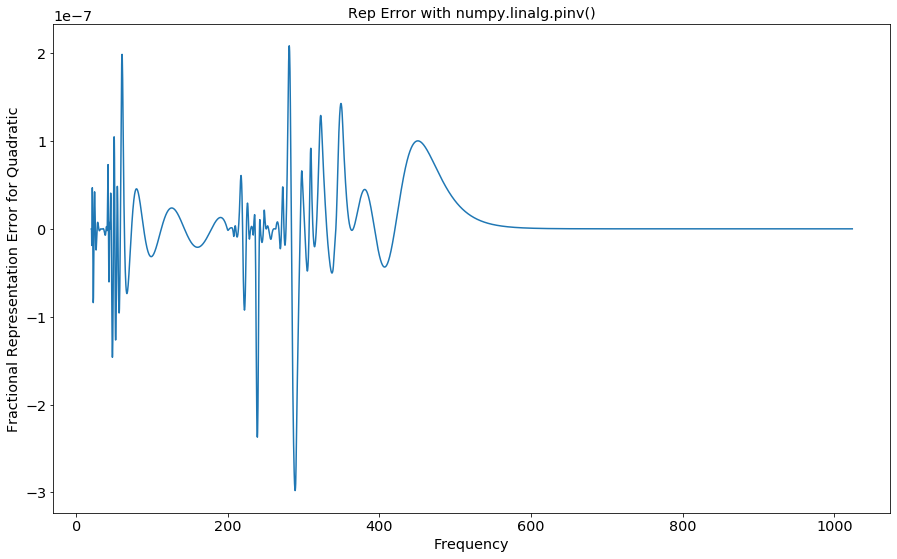

In [15]:
test_mc_quad =22
test_q_quad = 1.2
test_s1_quad = [0.0, 0.1, 0.0]
test_s2_quad = [0.0, 0.0, 0.0]
test_ecc_quad = 0
test_lambda1_quad = 0
test_lambda2_quad = 0
test_iota_quad = 1.9
test_phiref_quad = 0.6

pyroq.testrep_quad(b_quad, emp_nodes_quad, test_mc_quad, test_q_quad, test_s1_quad, test_s2_quad, test_ecc_quad, test_lambda1_quad, test_lambda2_quad, test_iota_quad, test_phiref_quad, distance, deltaF, f_min, f_max, waveFlags, approximant)
